# Final Project

This notebook is adapted from here: https://aiqm.github.io/torchani/examples/nnp_training.html

## Data preparation/processing

In [1]:
# Print out file path
!pwd

/global/home/users/dylanddo/chem277b_final


In [2]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani
import torch.optim as optim

### Use GPU

In [3]:
# Check if CUDA is available & set device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Set up AEV computer

#### AEV: Atomic Environment Vector (atomic features)

Ref: Chem. Sci., 2017, 8, 3192

In [4]:
# Initialize AEV computer
def init_aev_computer():
    Rcr = 5.2 # radial cutoff radius
    Rca = 3.5 # angular cutoff radius
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4 # number of different atoms (H, C, O, N)
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

# Create AEV computer instance & print out length
aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


### Prepare dataset & split

In [5]:
# Load dataset and preprocess for training
def load_ani_dataset(dspath):
    # Self energies for H, C, O, N
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None) # helper object for adding and subtracting self atomic energies
    species_order = ['H', 'C', 'N', 'O']

    # Load dataset, subtract self energies, and shuffle
    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

# Load ANI dataset
dataset = load_ani_dataset("ani_gdb_s01_to_s04.h5")

In [6]:
# Use dataset.split method to do 80/10/10 split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1) # 80% training, 10% validation, 10% testing

# Show amount of training data vs total data
print(f"Training data size: {len(train_data)}")
print(f"Total data size: {len(dataset)}")

Training data size: 691918
Total data size: 864898


### Batching

In [7]:
batch_size = 8192 # number of samples per batch to load
# use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

In [8]:
# Show that batching is working correctly
# List of data loaders
data_loaders = [train_data_loader, val_data_loader, test_data_loader]

# Iterate over data loaders and batches
for data_loader in data_loaders:
    for batch in data_loader: # iterate each data loader
        print(f'Batch Keys: {list(batch.keys())}') # print current batch keys
        for key in batch.keys(): # for each key in batch
            print(f'Shape of {key}: {batch[key].shape}') # print shape of tensor associated w/ current key in batch

Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinates: torch.Size([8192, 14, 3])
Shape of energies: torch.Size([8192])
Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinates: torch.Size([8192, 14, 3])
Shape of energies: torch.Size([8192])
Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinates: torch.Size([8192, 14, 3])
Shape of energies: torch.Size([8192])
Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinates: torch.Size([8192, 14, 3])
Shape of energies: torch.Size([8192])
Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinates: torch.Size([8192, 14, 3])
Shape of energies: torch.Size([8192])
Batch Keys: ['species', 'coordinates', 'energies']
Shape of species: torch.Size([8192, 14])
Shape of coordinat

### Torchani API

In [9]:
# Initialize AtomicNet class
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128), # 384 input feature to 128 output
            nn.ReLU(), # ReLU activation
            nn.Linear(128, 1) # 128 input features to 1 output
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize models for each atom type
net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torchani.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [10]:
train_data_batch = next(iter(train_data_loader))

loss_func = nn.MSELoss() # mean squared error loss function for model evaluation

# move each batch key to GPU
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies) # calculate loss between true and predicted energies
print(loss)

tensor(0.5176, device='cuda:0', grad_fn=<MseLossBackward0>)


#  Network Construction and Workflow Development

In [11]:
import matplotlib.pyplot as plt
import time

# Decorator function to measure execute time of a function (will be used in ANITrainer train)
def timeit(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func: {f.__name__} took: {te-ts:.4f} sec on {device}')
        return result
    return timed

# Class to train ANI model on predicting molecular energy predictions
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.loss_function = nn.MSELoss()# definition of loss function


    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True, verbose=True):
        self.model.train()

        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()

        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf

        if verbose:
            iterator = range(self.epoch)
        else:
            iterator = tqdm(range(self.epoch), leave=True)

        for i in iterator:
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                _, pred_energies = model((species, coords))
                
                # compute loss
                batch_loss = self.loss_function(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = train_data_batch['species'].shape[0] / len(train_data)
                train_epoch_loss += batch_importance * batch_loss.detach().cpu().item()
            
            # self.evaluate to get loss/MAE/RMSE on the validation set 
            val_epoch_loss, mae, rmse = self.evaluate(val_data)
            if verbose: 
                print(f'Epoch {i+1}: , MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol')
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()

        if draw_curve:
            # Plot train loss and validation loss
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            # Calculate the RMSE for plotting
            epoch = np.arange(self.epoch)
            ax.plot(epoch, np.sqrt(train_loss_list), label='Train')
            ax.plot(epoch, np.sqrt(val_loss_list),label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("RMSE")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list


    def evaluate(self, data, draw_plot=False):
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        total_loss = 0.0
        
        # init energies containers
        true_energies_all = []
        pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                _, pred_energies = model((species, coords))
                
                # compute loss
                batch_loss = self.loss_function(true_energies, pred_energies)

                batch_importance = batch_data['species'].shape[0] / len(data)
                total_loss += batch_importance * batch_loss.detach().cpu().item()
                
                # store true and predicted energies
                true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())
        true_energies_all = np.concatenate(true_energies_all)
        pred_energies_all = np.concatenate(pred_energies_all)

        # Report mean absolute error (MAE) and root mean square error (RMSE)
        # The unit of energies in the dataset is hartree
        # 1 hartree = 627.5094738898777 kcal/mol
        # MAE = mean(|true - pred|)
        # RMSE = sqrt(mean( (true-pred)^2 ))
        hartree2kcalmol = 627.5094738898777
        mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
        rmse = np.sqrt(np.mean((true_energies_all - pred_energies_all) ** 2)) * hartree2kcalmol

        if draw_plot:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss, mae, rmse

## Load dataset with 1 heavy atom

Train/Total: 8640/10800
Sequential - Number of parameters: 197636


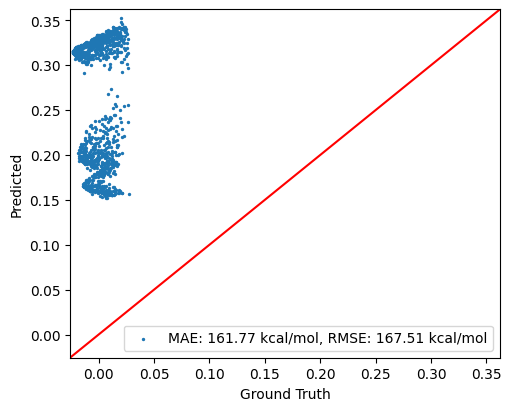

In [14]:
# Load dataset with 1 heavy atom
# train/val/test = 80/10/10 split
dataset = load_ani_dataset("ani_gdb_s01.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model, batch_size=2000, learning_rate=1e-3, epoch=100, l2=1e-5)

loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: , MAE: 22.95 kcal/mol, RMSE: 27.56 kcal/mol
Epoch 2: , MAE: 20.68 kcal/mol, RMSE: 22.14 kcal/mol
Epoch 3: , MAE: 21.66 kcal/mol, RMSE: 23.80 kcal/mol
Epoch 4: , MAE: 16.48 kcal/mol, RMSE: 19.08 kcal/mol
Epoch 5: , MAE: 14.70 kcal/mol, RMSE: 17.78 kcal/mol
Epoch 6: , MAE: 12.37 kcal/mol, RMSE: 14.05 kcal/mol
Epoch 7: , MAE: 13.48 kcal/mol, RMSE: 14.96 kcal/mol
Epoch 8: , MAE: 12.92 kcal/mol, RMSE: 14.84 kcal/mol
Epoch 9: , MAE: 5.55 kcal/mol, RMSE: 6.57 kcal/mol
Epoch 10: , MAE: 11.57 kcal/mol, RMSE: 13.66 kcal/mol
Epoch 11: , MAE: 6.56 kcal/mol, RMSE: 8.26 kcal/mol
Epoch 12: , MAE: 8.09 kcal/mol, RMSE: 9.77 kcal/mol
Epoch 13: , MAE: 5.97 kcal/mol, RMSE: 7.30 kcal/mol
Epoch 14: , MAE: 7.95 kcal/mol, RMSE: 9.08 kcal/mol
Epoch 15: , MAE: 5.78 kcal/mol, RMSE: 6.76 kcal/mol
Epoch 16: , MAE: 4.68 kcal/mol, RMSE: 6.15 kcal/mol
Epoch 17: , MAE: 5.69 kcal/mol, RMSE: 7.13 kcal/mol
Epoch 18: , MAE: 4.04 kcal/mol, RMSE: 5.11 kcal/mol
Epoch 19: , MAE: 5.32 kcal/

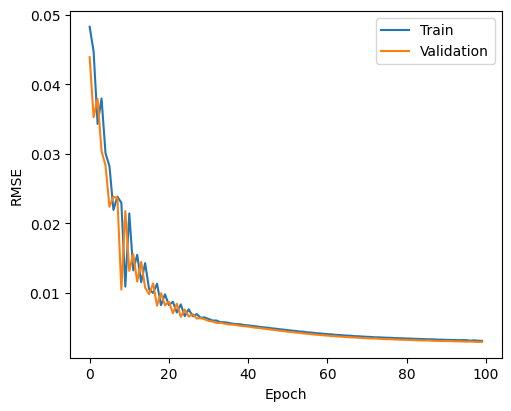

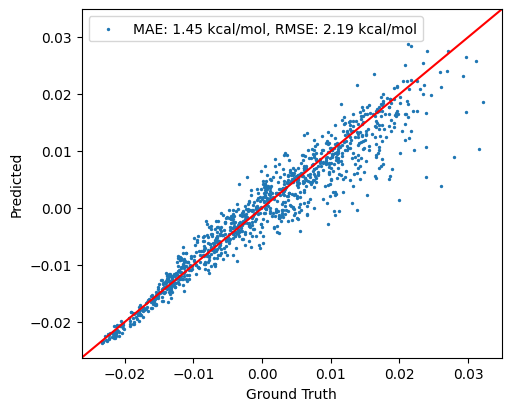

In [13]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: , MAE: 20.90 kcal/mol, RMSE: 28.58 kcal/mol
Epoch 2: , MAE: 78.20 kcal/mol, RMSE: 84.97 kcal/mol
Epoch 3: , MAE: 71.10 kcal/mol, RMSE: 79.24 kcal/mol
Epoch 4: , MAE: 30.94 kcal/mol, RMSE: 33.56 kcal/mol
Epoch 5: , MAE: 20.78 kcal/mol, RMSE: 22.17 kcal/mol
Epoch 6: , MAE: 46.80 kcal/mol, RMSE: 49.40 kcal/mol
Epoch 7: , MAE: 47.83 kcal/mol, RMSE: 50.92 kcal/mol
Epoch 8: , MAE: 29.76 kcal/mol, RMSE: 31.69 kcal/mol
Epoch 9: , MAE: 6.27 kcal/mol, RMSE: 8.08 kcal/mol
Epoch 10: , MAE: 20.55 kcal/mol, RMSE: 23.07 kcal/mol
Epoch 11: , MAE: 29.60 kcal/mol, RMSE: 32.82 kcal/mol
Epoch 12: , MAE: 25.04 kcal/mol, RMSE: 27.33 kcal/mol
Epoch 13: , MAE: 11.17 kcal/mol, RMSE: 12.52 kcal/mol
Epoch 14: , MAE: 9.61 kcal/mol, RMSE: 10.95 kcal/mol
Epoch 15: , MAE: 18.48 kcal/mol, RMSE: 19.77 kcal/mol
Epoch 16: , MAE: 18.09 kcal/mol, RMSE: 19.42 kcal/mol
Epoch 17: , MAE: 10.23 kcal/mol, RMSE: 11.25 kcal/mol
Epoch 18: , MAE: 4.24 kcal/mol, RMSE: 5.51 kcal/mol
Epoch 19: , MA

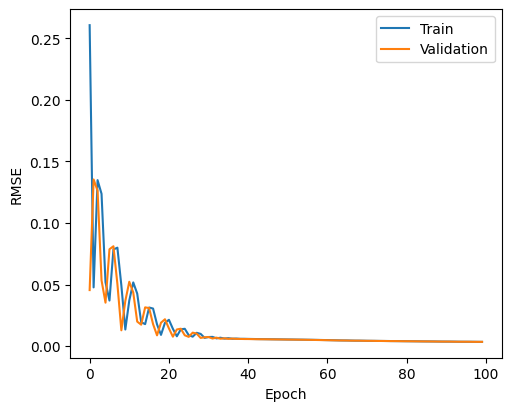

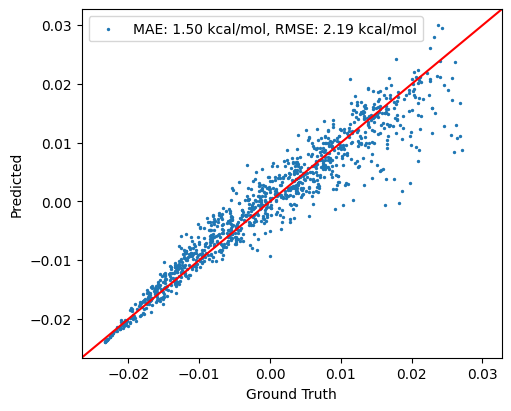

In [15]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

## Load dataset with n (different from 1) heavy atoms

Train/Total: 40769/50962
Sequential - Number of parameters: 197636


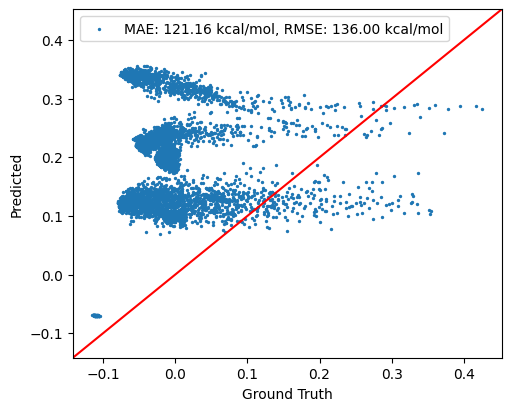

In [20]:
# Load dataset with n (different from 1) heavy atom
# train/val/test = 80/10/10 split
dataset = load_ani_dataset("ani_gdb_s02.h5") # 2 heavy atoms
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model, batch_size=3000, learning_rate=1e-3, epoch=120, l2=1e-5)

loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: , MAE: 41.76 kcal/mol, RMSE: 52.14 kcal/mol
Epoch 2: , MAE: 47.19 kcal/mol, RMSE: 56.49 kcal/mol
Epoch 3: , MAE: 41.39 kcal/mol, RMSE: 46.97 kcal/mol
Epoch 4: , MAE: 15.84 kcal/mol, RMSE: 25.54 kcal/mol
Epoch 5: , MAE: 13.86 kcal/mol, RMSE: 22.26 kcal/mol
Epoch 6: , MAE: 18.71 kcal/mol, RMSE: 24.43 kcal/mol
Epoch 7: , MAE: 14.18 kcal/mol, RMSE: 20.88 kcal/mol
Epoch 8: , MAE: 11.93 kcal/mol, RMSE: 17.48 kcal/mol
Epoch 9: , MAE: 8.90 kcal/mol, RMSE: 15.20 kcal/mol
Epoch 10: , MAE: 8.90 kcal/mol, RMSE: 14.40 kcal/mol
Epoch 11: , MAE: 8.05 kcal/mol, RMSE: 13.78 kcal/mol
Epoch 12: , MAE: 7.70 kcal/mol, RMSE: 13.22 kcal/mol
Epoch 13: , MAE: 7.79 kcal/mol, RMSE: 12.97 kcal/mol
Epoch 14: , MAE: 7.28 kcal/mol, RMSE: 12.53 kcal/mol
Epoch 15: , MAE: 7.21 kcal/mol, RMSE: 12.24 kcal/mol
Epoch 16: , MAE: 6.92 kcal/mol, RMSE: 11.87 kcal/mol
Epoch 17: , MAE: 6.71 kcal/mol, RMSE: 11.59 kcal/mol
Epoch 18: , MAE: 6.59 kcal/mol, RMSE: 11.30 kcal/mol
Epoch 19: , MAE: 6.

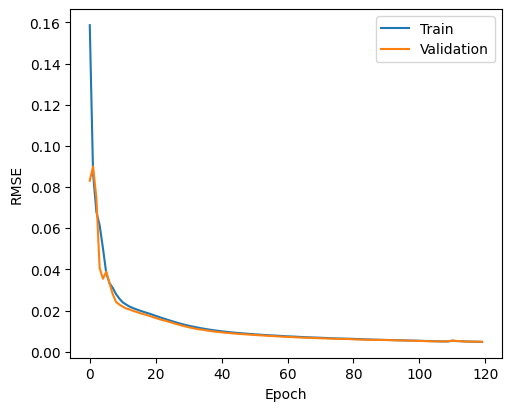

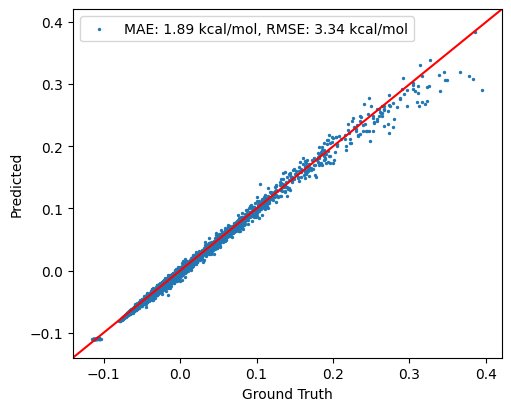

In [13]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: , MAE: 43.57 kcal/mol, RMSE: 54.93 kcal/mol
Epoch 2: , MAE: 43.22 kcal/mol, RMSE: 54.46 kcal/mol
Epoch 3: , MAE: 23.53 kcal/mol, RMSE: 31.44 kcal/mol
Epoch 4: , MAE: 21.01 kcal/mol, RMSE: 29.56 kcal/mol
Epoch 5: , MAE: 16.01 kcal/mol, RMSE: 21.60 kcal/mol
Epoch 6: , MAE: 15.12 kcal/mol, RMSE: 21.40 kcal/mol
Epoch 7: , MAE: 12.38 kcal/mol, RMSE: 18.17 kcal/mol
Epoch 8: , MAE: 10.55 kcal/mol, RMSE: 17.01 kcal/mol
Epoch 9: , MAE: 10.35 kcal/mol, RMSE: 15.75 kcal/mol
Epoch 10: , MAE: 8.83 kcal/mol, RMSE: 14.74 kcal/mol
Epoch 11: , MAE: 8.95 kcal/mol, RMSE: 14.23 kcal/mol
Epoch 12: , MAE: 8.18 kcal/mol, RMSE: 13.49 kcal/mol
Epoch 13: , MAE: 7.71 kcal/mol, RMSE: 12.92 kcal/mol
Epoch 14: , MAE: 7.47 kcal/mol, RMSE: 12.52 kcal/mol
Epoch 15: , MAE: 7.20 kcal/mol, RMSE: 12.13 kcal/mol
Epoch 16: , MAE: 6.99 kcal/mol, RMSE: 11.70 kcal/mol
Epoch 17: , MAE: 6.72 kcal/mol, RMSE: 11.32 kcal/mol
Epoch 18: , MAE: 6.49 kcal/mol, RMSE: 10.93 kcal/mol
Epoch 19: , MAE: 6

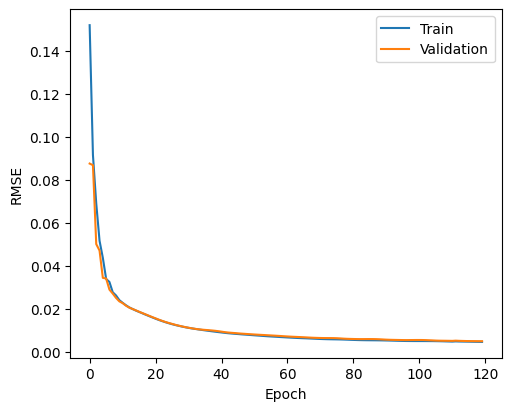

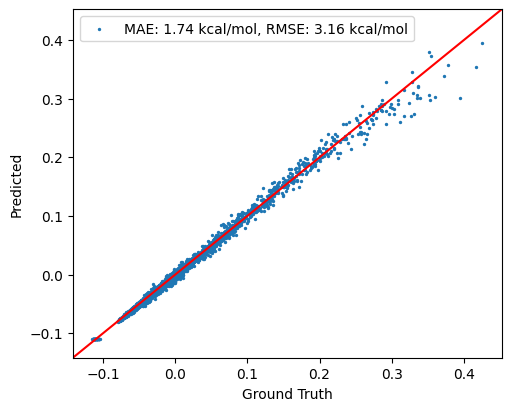

In [21]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

# Architecture, hyperparameters and regularization

## Model & Training with Full data set

### Trial 7: ANITrainer(model, batch_size=3000, learning_rate=1e-3, epoch=150, l2=1e-6)

Train/Total: 691918/864898
Sequential - Number of parameters: 197636


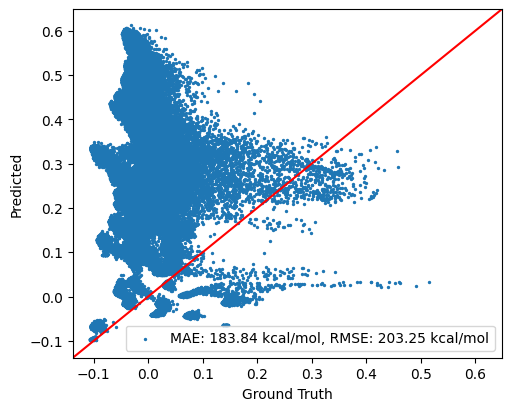

In [32]:
# train/val/test = 80/10/10 split
dataset = load_ani_dataset("ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8,0.1,None)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)


# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model, 
                     batch_size=3000, # number of samples per batch
                     learning_rate=1e-3, # step size (learning rate) 
                     epoch=150, # number of times to iterate over dataset
                     l2=1e-6) # weight decay
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

### Before training observation

Scatter plot showing the actual (ground truth) versus the predicted molecular energies. The scatterplot the MAE of 183.84 kcal/mol and RMSE of 203.25 kcal/mol predictions before training (predicted energies before training should be poor).

###  Output analysis/Visualization

Initialize training data...


100%|██████████| 150/150 [23:34<00:00,  9.43s/it]


func: train took: 1439.9259 sec on cuda


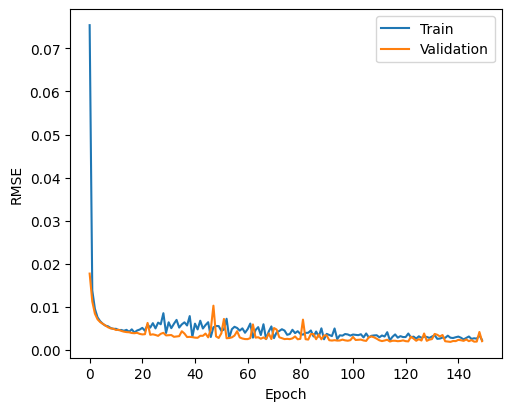

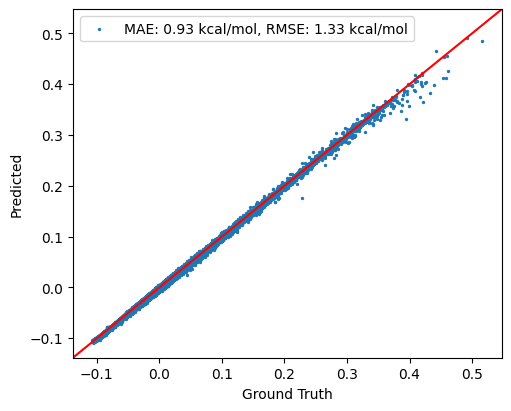

In [33]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=False)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

### After training observation

Observed are the scatter plots showing the actual (ground truth) versus the predicted molecular energies and training/validation loss curve. The top plot shows training phase (blue) and the validation phase (orange) are shown in the line plot. Over epochs, the phases showcase how the RMSE rapidly decreases. The bottom plot demonstrates the points tightly clustered around the line of perfect accuracy with an MAE of 0.93 kcal/mol and an RMSE of 1.33 kcal/mol.

### Sub-data sets training and modeling

Test model trained on s01_to_s04 on s01 data
Test model trained on s01_to_s04 on s02 data
Test model trained on s01_to_s04 on s03 data
Test model trained on s01_to_s04 on s04 data


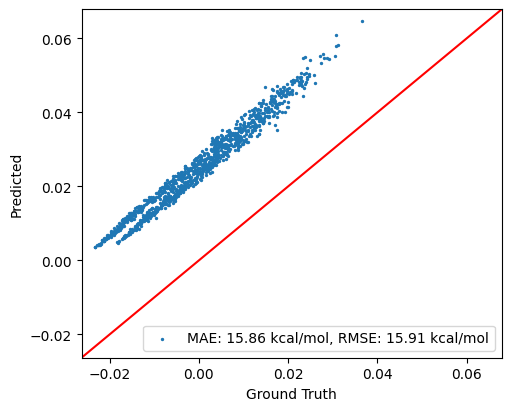

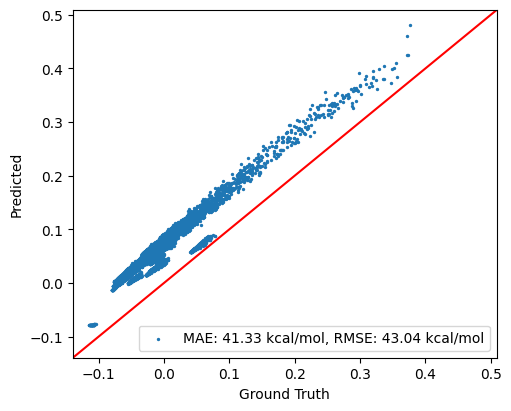

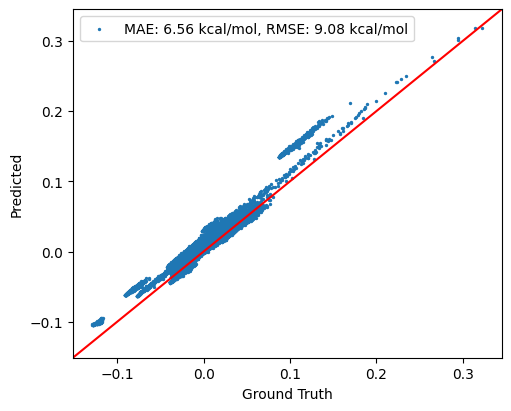

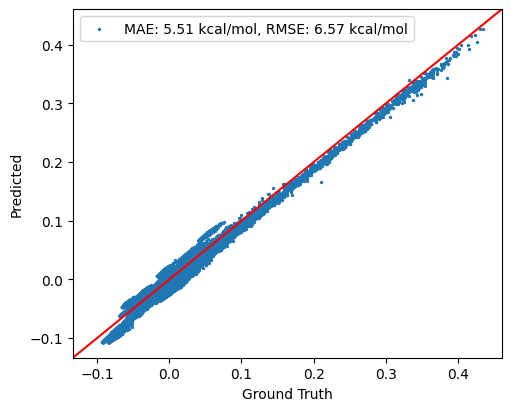

In [34]:
for i in range(1,5):
    print(f'Test model trained on s01_to_s04 on s0{i} data')
    dataset = load_ani_dataset(f"ani_gdb_s0{i}.h5")
    train_data, val_data, test_data = dataset.split(0.8,0.1,None)
    loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

### Sub-data Observations

From the plots created above after testing the trained model on each smaller dataset, the MAE and RMSE decreased. As the number of n heavy atoms increased as printed out in the plots, the MAE and RMSE is lower suggesting that the model is predicting the molecular energies more accurately. This may be due to the data with more complex molecules (more n heavy atoms) that have more information help make the model make better predictions